# Task 3: Floating-Point Associativity & Round-off Analysis## OverviewThis notebook demonstrates and analyzes the **non-associativity** of floating-point arithmetic:- **Multiple reduction orders** (sequential, reverse, tree, sorted)- **Different data distributions** (mixed magnitude, pathological, normal)- **Error quantification** vs double-precision reference- **GPU vs CPU comparison** showing platform-dependent rounding- **Visualization** of error growth with array size**Key Insight:** Parallel reductions (like GPU tree reduction) can produce different results than sequential reductions due to different rounding propagation paths.

## 1. Environment SetupCheck CUDA environment and GPU specifications.

In [2]:
# ================================================
# System + CUDA + GPU Runtime Info
# ================================================

from numba import cuda
import platform
import numba

print("=== Python Environment Info ===")
print(f"Python Version      : {platform.python_version()}")
print(f"Platform            : {platform.platform()}")
print(f"Numba Version       : {numba.__version__}")

print("\n=== CUDA + GPU Info ===")
print(f"CUDA Available      : {cuda.is_available()}")

try:
    print(f"CUDA Runtime Version: {cuda.runtime.get_version()}")
except Exception as e:
    print(f"CUDA Runtime Version: Not available ({e})")

try:
    device = cuda.get_current_device()
    free_mem, total_mem = cuda.current_context().get_memory_info()
    print(f"GPU Device Name     : {device.name}")
    print(f"Compute Capability  : {device.compute_capability}")
    print(f"Total Memory (MB)   : {total_mem / 1024 ** 2:.2f} MB")
    print(f"Free Memory (MB)    : {free_mem / 1024 ** 2:.2f} MB")
    print(f"Max Threads/Block   : {device.MAX_THREADS_PER_BLOCK}")
    print(f"Max Block Dim       : {device.MAX_BLOCK_DIM_X}, {device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z}")
    print(f"Max Grid Dim        : {device.MAX_GRID_DIM_X}, {device.MAX_GRID_DIM_Y}, {device.MAX_GRID_DIM_Z}")
    print(f"Multiprocessors     : {device.MULTIPROCESSOR_COUNT}")
    print(f"Warp Size           : {device.WARP_SIZE}")
    print(f"Max Shared Mem/Block: {device.MAX_SHARED_MEMORY_PER_BLOCK / 1024:.2f} KB")
except cuda.cudadrv.error.CudaSupportError as e:
    print("CUDA Device Info: Not available (No compatible GPU?)")

print("\n=== nvidia-smi (if available) ===")
!nvidia-smi || echo "nvidia-smi not available in this environment."

=== Python Environment Info ===
Python Version      : 3.12.12
Platform            : Linux-6.6.105+-x86_64-with-glibc2.35
Numba Version       : 0.60.0

=== CUDA + GPU Info ===
CUDA Available      : True
CUDA Runtime Version: (12, 6)
GPU Device Name     : b'Tesla T4'
Compute Capability  : (7, 5)
Total Memory (MB)   : 15095.06 MB
Free Memory (MB)    : 14992.12 MB
Max Threads/Block   : 1024
Max Block Dim       : 1024, 1024, 64
Max Grid Dim        : 2147483647, 65535, 65535
Multiprocessors     : 40
Warp Size           : 32
Max Shared Mem/Block: 48.00 KB

=== nvidia-smi (if available) ===
Wed Nov 26 21:01:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Tem

## 2. Imports and Test ConfigurationImport required libraries and define test array sizes.**Test Sizes:** Range from 1K to 50M elements to observe how error scales with problem size.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

print("=== Task 3: Associativity Experiment ===")
print("Demonstrating non-associativity of floating-point operations")

# Test sizes
test_sizes = [1_000, 10_000, 100_000, 1_000_000, 10_000_000, 50_000_000]

=== Task 3: Associativity Experiment ===
Demonstrating non-associativity of floating-point operations


## 3. Reduction Method ImplementationsImplement multiple reduction algorithms to demonstrate associativity effects:**Methods:**1. **`sequential_sum()`** - Standard left-to-right summation     `(((...((a₁ + a₂) + a₃) + ...) + aₙ)`2. **`reverse_sequential_sum()`** - Right-to-left summation     `(a₁ + (a₂ + (a₃ + (...(aₙ₋₁ + aₙ)...))))`3. **`tree_reduction_sum()`** - Binary tree reduction (mimics GPU reduction)     Pairs elements: `(a₁+a₂), (a₃+a₄), ...` then reduces recursively4. **`sorted_sum()`** - Sum in ascending order by magnitude     Reduces catastrophic cancellation by adding small values first**Why Different Results?**  Each method accumulates rounding errors differently. The order of operations affects how errors propagate through the computation.

In [4]:
def sequential_sum(data):
    """Standard left-to-right sum"""
    result = 0.0
    for x in data:
        result += x
    return result

def reverse_sequential_sum(data):
    """Right-to-left sum"""
    result = 0.0
    for x in reversed(data):
        result += x
    return result

def tree_reduction_sum(data):
    """Binary tree reduction (like GPU)"""
    arr = data.copy()
    while len(arr) > 1:
        new_arr = []
        for i in range(0, len(arr), 2):
            if i + 1 < len(arr):
                new_arr.append(arr[i] + arr[i + 1])
            else:
                new_arr.append(arr[i])
        arr = new_arr
    return arr[0]

def sorted_sum(data):
    """Sum in ascending order by magnitude"""
    sorted_data = sorted(data, key=abs)
    return sequential_sum(sorted_data)

print("Reduction methods ready")

Reduction methods ready


## 4. Data Distribution GeneratorsCreate different data distributions to expose varying degrees of floating-point error:**1. Mixed Data (`generate_mixed_data`)**- Half large values (1e6 to 1e8)- Half small values (1e-3 to 1e-1)- Randomly shuffled- **Exposes:** Catastrophic cancellation when large and small values interact**2. Pathological Data (`generate_pathological_data`)**- Pattern: [1e8, 1.0, -1e8, 1e8, 1.0, -1e8, ...]- Large positive/negative values nearly cancel- **Exposes:** Worst-case rounding error accumulation**3. Normal Data (`generate_normal_data`)**- Standard normal distribution (mean=0, std=1)- Typical real-world scenario- **Exposes:** Moderate error accumulation

In [5]:
def generate_mixed_data(size):
    """Mix of large and small numbers"""
    np.random.seed(42)
    large = np.random.uniform(1e6, 1e8, size//2).astype(np.float32)
    small = np.random.uniform(1e-3, 1e-1, size//2).astype(np.float32)
    data = np.concatenate([large, small])
    np.random.shuffle(data)
    return data

def generate_pathological_data(size):
    """Alternating large positive/negative"""
    data = []
    for i in range(size):
        if i % 3 == 0:
            data.append(1e8)
        elif i % 3 == 1:
            data.append(1.0)
        else:
            data.append(-1e8)
    return np.array(data, dtype=np.float32)

def generate_normal_data(size):
    """Normal random data"""
    np.random.seed(42)
    return np.random.randn(size).astype(np.float32)

print("Data generators ready")

Data generators ready


## 5. Associativity ExperimentsRun comprehensive experiments testing all reduction methods on all data types.**Procedure for each (data type, array size) pair:**1. Generate data using appropriate generator2. Apply all 4 reduction methods (sequential, reverse, tree, sorted)3. Compute reference using **double-precision** (float64) NumPy sum4. Calculate absolute error for each method vs. double-precision reference5. Report maximum error across methods**Reference Choice:**  Double-precision is used as "ground truth" because float64 has ~16 decimal digits of precision vs. ~7 for float32, making rounding errors negligible for these test sizes.

In [6]:
def run_associativity_experiments():
    results = {}

    data_types = {
        'mixed': generate_mixed_data,
        'pathological': generate_pathological_data,
        'normal': generate_normal_data
    }

    for data_name, data_func in data_types.items():
        print(f"\n{'='*50}")
        print(f"TESTING {data_name.upper()} DATA")
        print(f"{'='*50}")

        size_results = {}

        for size in test_sizes:
            print(f"\nSize: {size:,}")
            data = data_func(size)

            # Different reduction methods
            methods = {
                'sequential': sequential_sum(data),
                'reverse': reverse_sequential_sum(data),
                'tree': tree_reduction_sum(data),
                'sorted': sorted_sum(data),
                'numpy': float(np.sum(data)),
                'double_ref': float(np.sum(data.astype(np.float64)))
            }

            # Calculate errors vs double precision
            ref = methods['double_ref']
            errors = {k: abs(v - ref) for k, v in methods.items() if k != 'double_ref'}

            size_results[size] = {'methods': methods, 'errors': errors}

            max_error = max(errors.values())
            print(f"  Max error: {max_error:.2e}")

        results[data_name] = size_results

    return results

experiment_results = run_associativity_experiments()


TESTING MIXED DATA

Size: 1,000
  Max error: 8.19e+03

Size: 10,000
  Max error: 1.97e+05

Size: 100,000
  Max error: 1.05e+07

Size: 1,000,000
  Max error: 1.03e+09

Size: 10,000,000
  Max error: 1.50e+12

Size: 50,000,000
  Max error: 9.07e+13

TESTING PATHOLOGICAL DATA

Size: 1,000
  Max error: 3.36e+02

Size: 10,000
  Max error: 3.34e+03

Size: 100,000
  Max error: 3.33e+04

Size: 1,000,000
  Max error: 3.33e+05

Size: 10,000,000
  Max error: 3.33e+06

Size: 50,000,000
  Max error: 1.67e+07

TESTING NORMAL DATA

Size: 1,000
  Max error: 3.24e-05

Size: 10,000
  Max error: 5.53e-05

Size: 100,000
  Max error: 1.90e-03

Size: 1,000,000
  Max error: 2.49e-02

Size: 10,000,000
  Max error: 5.22e-02

Size: 50,000,000
  Max error: 3.49e-01


## 6. GPU vs CPU Associativity ComparisonCompare reduction results between CPU (NumPy) and GPU (PyTorch CUDA).**Key Question:** Do GPU and CPU produce different results due to different execution orders?**Comparison:**- **CPU NumPy:** Uses optimized CPU instructions (SSE/AVX)- **CPU Sequential:** Pure Python loop (left-to-right)- **GPU PyTorch:** CUDA reduction kernel (tree-based)- **Reference:** Double-precision CPU sum**Expected:** GPU and CPU may differ slightly due to:- Different reduction topologies (tree vs sequential)- Different floating-point instruction sets- Different compiler optimizations

In [7]:
def gpu_cpu_associativity():
    print(f"\n{'='*60}")
    print("GPU vs CPU ASSOCIATIVITY COMPARISON")
    print(f"{'='*60}")

    results = {}

    for size in test_sizes:
        np.random.seed(42)
        data = np.random.randn(size).astype(np.float32)

        # CPU methods
        cpu_numpy = float(np.sum(data))
        cpu_sequential = sequential_sum(data)
        cpu_double = float(np.sum(data.astype(np.float64)))

        # GPU methods
        data_gpu = torch.tensor(data, device='cuda:0')
        gpu_torch = float(torch.sum(data_gpu))

        # Errors
        errors = {
            'cpu_numpy': abs(cpu_numpy - cpu_double),
            'cpu_sequential': abs(cpu_sequential - cpu_double),
            'gpu_torch': abs(gpu_torch - cpu_double)
        }

        results[size] = {
            'cpu_numpy': cpu_numpy,
            'cpu_sequential': cpu_sequential,
            'gpu_torch': gpu_torch,
            'double_ref': cpu_double,
            'errors': errors
        }

        print(f"{size:<10,} CPU: {errors['cpu_numpy']:.2e}, GPU: {errors['gpu_torch']:.2e}")

    return results

gpu_cpu_results = gpu_cpu_associativity()


GPU vs CPU ASSOCIATIVITY COMPARISON
1,000      CPU: 2.28e-06, GPU: 3.77e-07
10,000     CPU: 1.08e-05, GPU: 3.19e-06
100,000    CPU: 4.64e-05, GPU: 6.80e-05
1,000,000  CPU: 4.59e-04, GPU: 9.30e-05
10,000,000 CPU: 1.69e-03, GPU: 1.41e-04
50,000,000 CPU: 2.01e-03, GPU: 1.89e-03


## 7. Detailed Results TablePrint comprehensive results showing:- **Result value** from each reduction method- **Absolute error** vs double-precision reference- **Organized by data type** (mixed, pathological, normal)This table reveals:- Which methods are most/least accurate- How error scales with array size- Data distribution sensitivity

In [8]:
print(f"\n{'='*80}")
print("DETAILED ASSOCIATIVITY RESULTS")
print(f"{'='*80}")

for data_type, size_data in experiment_results.items():
    print(f"\n{data_type.upper()} DATA:")
    print(f"{'Size':<12} {'Method':<12} {'Result':<15} {'Error':<12}")
    print("-" * 55)

    for size, results in size_data.items():
        methods = results['methods']
        errors = results['errors']

        for i, (method, result) in enumerate(methods.items()):
            if method != 'double_ref':
                size_str = f"{size:,}" if i == 0 else ""
                error = errors[method]
                print(f"{size_str:<12} {method:<12} {result:<15.6f} {error:<12.2e}")
        print("-" * 55)


DETAILED ASSOCIATIVITY RESULTS

MIXED DATA:
Size         Method       Result          Error       
-------------------------------------------------------
1,000        sequential   25178812416.000000 8.19e+03    
             reverse      25178810368.000000 6.14e+03    
             tree         25178804224.000000 0.00e+00    
             sorted       25178812416.000000 8.19e+03    
             numpy        25178804224.000000 5.53e+02    
-------------------------------------------------------
10,000       sequential   250931642368.000000 1.97e+05    
             reverse      250931953664.000000 1.15e+05    
             tree         250931838976.000000 0.00e+00    
             sorted       250931822592.000000 1.64e+04    
             numpy        250931838976.000000 3.10e+03    
-------------------------------------------------------
100,000      sequential   2519370563584.000000 3.41e+06    
             reverse      2519375020032.000000 1.05e+06    
             tree         2

## 8. Error Scaling VisualizationPlot how absolute error grows with array size for each data distribution.**Plots (3 subplots):**1. **Mixed Data** - Shows severe error growth with cancellation2. **Pathological Data** - Shows catastrophic error accumulation3. **Normal Data** - Shows moderate, well-behaved error growth**Observations:**- **Log-log scale** reveals error growth rates- **Tree reduction** often has different error than sequential- **Sorted reduction** can reduce error by avoiding cancellation- **Error typically grows** with array size due to more operations

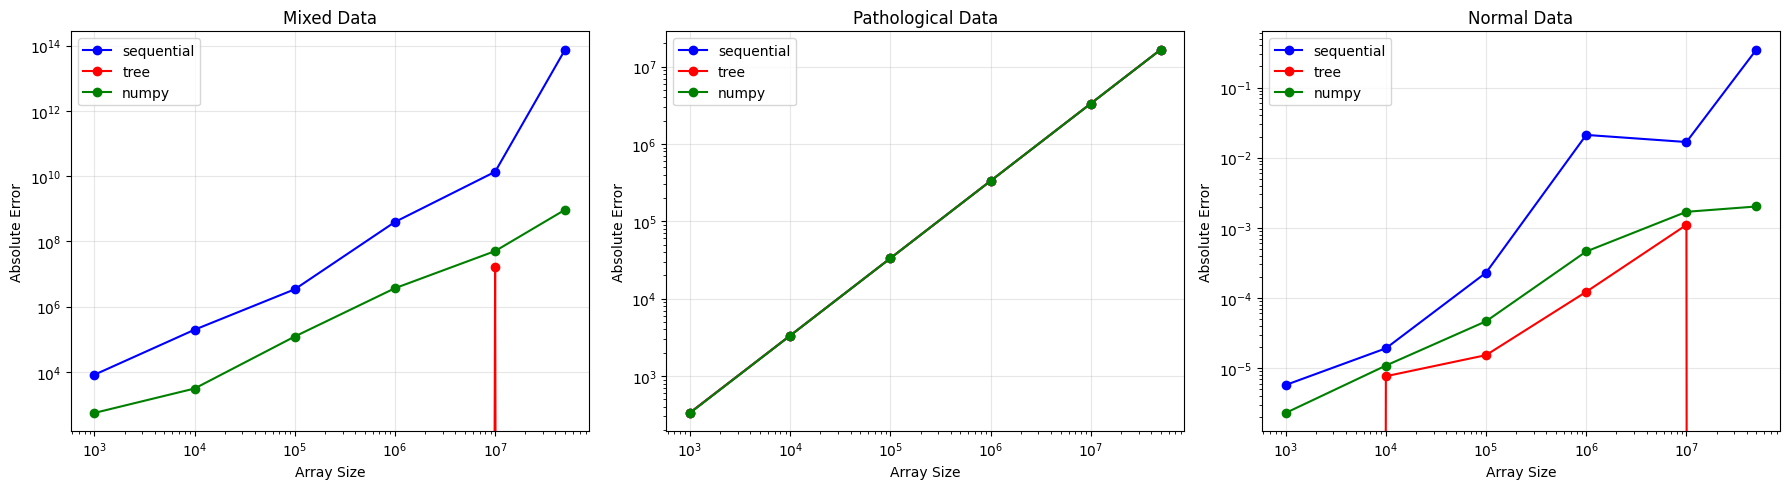

In [9]:
def plot_associativity_scaling():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    data_types = ['mixed', 'pathological', 'normal']
    methods = ['sequential', 'tree', 'numpy']
    colors = ['blue', 'red', 'green']

    for i, data_type in enumerate(data_types):
        ax = axes[i]
        size_data = experiment_results[data_type]

        for j, method in enumerate(methods):
            sizes = []
            errors = []

            for size, results in size_data.items():
                sizes.append(size)
                errors.append(results['errors'][method])

            ax.loglog(sizes, errors, 'o-', color=colors[j], label=method, markersize=6)

        ax.set_xlabel('Array Size')
        ax.set_ylabel('Absolute Error')
        ax.set_title(f'{data_type.title()} Data')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_associativity_scaling()

## 9. Simple 3-Number DemonstrationDemonstrate associativity failure with just **3 numbers** to make the concept concrete.**Example:**- `a = 1e8` (large positive)- `b = 1.0` (small positive)- `c = -1e8` (large negative)**Expected (exact math):** `a + b + c = 1.0`**Left-to-right:** `(a + b) + c`  - Step 1: `1e8 + 1.0 = 1e8` (1.0 lost due to limited precision)- Step 2: `1e8 + (-1e8) = 0.0`- **Result: 0.0** ❌**Right-to-left:** `a + (b + c)`  - Step 1: `1.0 + (-1e8) = -1e8` (1.0 lost)- Step 2: `1e8 + (-1e8) = 0.0`- **Result: 0.0** ❌**Why?** Float32 has only ~7 decimal digits. Adding 1.0 to 1e8 doesn't change the float32 representation.This demonstrates **catastrophic cancellation** and why `(a+b)+c ≠ a+(b+c)` in floating-point.

In [10]:
print(f"\n{'='*50}")
print("SIMPLE ASSOCIATIVITY DEMONSTRATION")
print(f"{'='*50}")

# Pathological case
a, b, c = np.float32(1e8), np.float32(1.0), np.float32(-1e8)

result1 = (a + b) + c  # Left-to-right
result2 = a + (b + c)  # Right-to-left

print(f"Values: a={a}, b={b}, c={c}")
print(f"(a + b) + c = {result1}")
print(f"a + (b + c) = {result2}")
print(f"Difference:   {abs(result1 - result2)}")
print(f"Expected:     {float(a) + float(b) + float(c)}")

print(f"\nThis shows associativity fails even with 3 numbers!")


SIMPLE ASSOCIATIVITY DEMONSTRATION
Values: a=100000000.0, b=1.0, c=-100000000.0
(a + b) + c = 0.0
a + (b + c) = 0.0
Difference:   0.0
Expected:     1.0

This shows associativity fails even with 3 numbers!
